# Sentiment & Emotion Analysis on Amazon Electronics Reviews


In [21]:
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer


In [22]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')   
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('vader_lexicon')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [17]:
df = pd.read_json("Electronics_5.json", lines=True)

df = df[['reviewText', 'overall']]
df = df.rename(columns={'reviewText': 'text', 'overall': 'rating'})

df = df.sample(20000, random_state=42).reset_index(drop=True)
df.head()


,text,rating
0,"Well, after trying out some Box Towers....that...",5
1,I ordered one for my wife and one for me. Afte...,5
2,muy buen producto... a full en juegos fHD.... ...,5
3,The sound quality of this unit is phenomenal. ...,5
4,It is good on keeping your cpu cool also down'...,4


In [23]:
def rating_to_sentiment(r):
    if r <= 2:
        return "negative"
    elif r == 3:
        return "neutral"
    return "positive"

df['sentiment_label'] = df['rating'].apply(rating_to_sentiment)
df['sentiment_label'].value_counts()


sentiment_label
positive    15916
negative     2274
neutral      1801
Name: count, dtype: int64

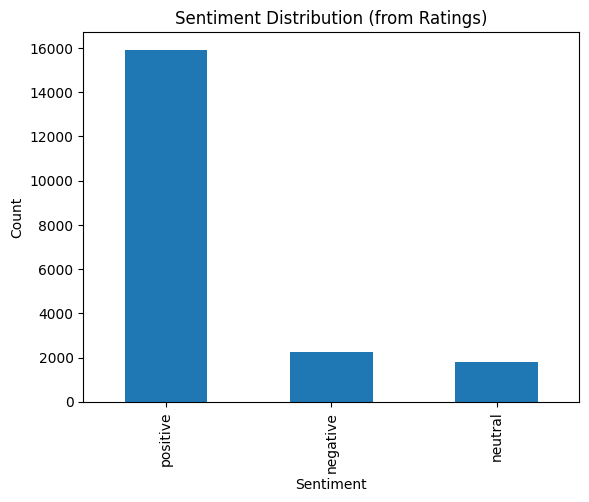

In [24]:
df['sentiment_label'].value_counts().plot(kind='bar')
plt.title("Sentiment Distribution (from Ratings)")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()


In [25]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    text = re.sub(r"<.*?>", "", text)
    text = re.sub(r"\d+", "", text)
    text = text.translate(str.maketrans("", "", string.punctuation))

    tokens = text.split()
    tokens = [w for w in tokens if w not in stop_words and len(w) > 2]
    tokens = [lemmatizer.lemmatize(w) for w in tokens]

    return " ".join(tokens)

df['clean_text'] = df['text'].apply(clean_text)
df = df[df['clean_text'].str.strip() != ""]
df.head()


,text,rating,sentiment_label,clean_text,text_len,word_count
0,"Well, after trying out some Box Towers....that...",5,positive,well trying box towersthat sounded like music ...,1177,194
1,I ordered one for my wife and one for me. Afte...,5,positive,ordered one wife one reading negative review p...,760,140
2,muy buen producto... a full en juegos fHD.... ...,5,positive,muy buen producto full juegos fhd hay problema...,150,24
3,The sound quality of this unit is phenomenal. ...,5,positive,sound quality unit phenomenal bose sounddock w...,507,93
4,It is good on keeping your cpu cool also down'...,4,positive,good keeping cpu cool also downt forget downlo...,133,24


In [26]:
df['text_len'] = df['text'].str.len()
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))

df['word_count'].describe()


count    19991.000000
mean       114.967485
std        159.695942
min          1.000000
25%         33.000000
50%         63.000000
75%        132.500000
max       5610.000000
Name: word_count, dtype: float64

### Preprocessing Steps Completed
- Lowercasing text  
- Removing URLs, HTML tags, digits, punctuation  
- Splitting into tokens using fast `.split()`  
- Removing stopwords  
- Lemmatizing words  
- Creating a new column `clean_text` for modeling  
- Dropping empty cleaned rows  
- Mapping star ratings to sentiment classes


In [27]:
from sklearn.model_selection import train_test_split

X = df['clean_text']
y = df['sentiment_label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train.shape, X_test.shape


((15992,), (3999,))

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    max_features=30000,
    ngram_range=(1, 2),
    min_df=5
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

X_train_tfidf.shape


(15992, 28036)

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

model = LogisticRegression(max_iter=1000, n_jobs=-1)
model.fit(X_train_tfidf, y_train)

y_pred = model.predict(X_test_tfidf)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.8322080520130033
              precision    recall  f1-score   support

    negative       0.82      0.36      0.50       455
     neutral       0.24      0.01      0.03       360
    positive       0.84      0.99      0.91      3184

    accuracy                           0.83      3999
   macro avg       0.63      0.46      0.48      3999
weighted avg       0.78      0.83      0.78      3999



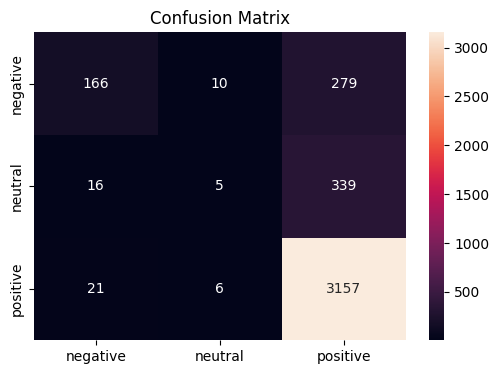

In [30]:
cm = confusion_matrix(y_test, y_pred, labels=['negative', 'neutral', 'positive'])

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=['negative', 'neutral', 'positive'],
            yticklabels=['negative', 'neutral', 'positive'])
plt.title("Confusion Matrix")
plt.show()


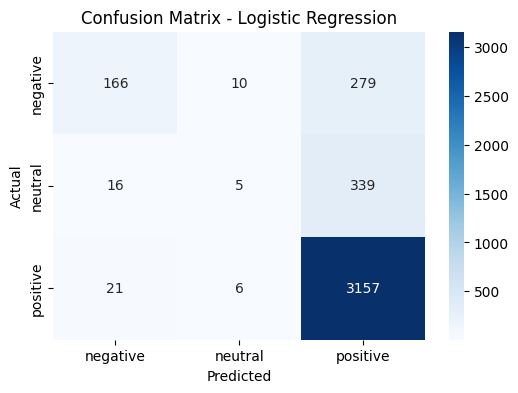

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred, labels=['negative', 'neutral', 'positive'])

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['negative', 'neutral', 'positive'],
            yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()


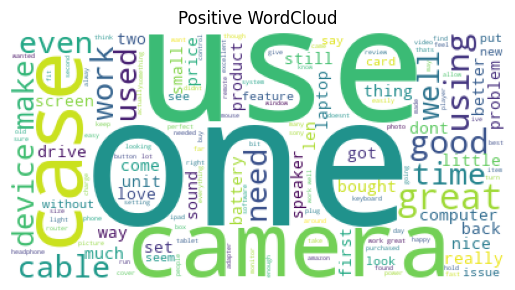

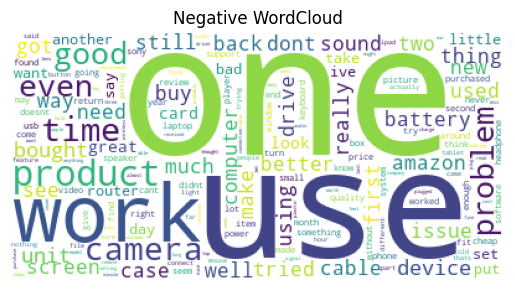

In [32]:
pos_text = " ".join(df[df['sentiment_label']=="positive"]["clean_text"])
neg_text = " ".join(df[df['sentiment_label']=="negative"]["clean_text"])

wc_pos = WordCloud(background_color="white").generate(pos_text)
plt.imshow(wc_pos); plt.axis("off"); plt.title("Positive WordCloud")
plt.show()

wc_neg = WordCloud(background_color="white").generate(neg_text)
plt.imshow(wc_neg); plt.axis("off"); plt.title("Negative WordCloud")
plt.show()


In [33]:
sia = SentimentIntensityAnalyzer()

def vader_sentiment(text):
    score = sia.polarity_scores(text)['compound']
    if score >= 0.05:
        return "positive"
    elif score <= -0.05:
        return "negative"
    return "neutral"

df['vader_sentiment'] = df['text'].apply(vader_sentiment)
df.head()


,text,rating,sentiment_label,clean_text,text_len,word_count,vader_sentiment
0,"Well, after trying out some Box Towers....that...",5,positive,well trying box towersthat sounded like music ...,1177,194,positive
1,I ordered one for my wife and one for me. Afte...,5,positive,ordered one wife one reading negative review p...,760,140,positive
2,muy buen producto... a full en juegos fHD.... ...,5,positive,muy buen producto full juegos fhd hay problema...,150,24,positive
3,The sound quality of this unit is phenomenal. ...,5,positive,sound quality unit phenomenal bose sounddock w...,507,93,positive
4,It is good on keeping your cpu cool also down'...,4,positive,good keeping cpu cool also downt forget downlo...,133,24,positive


In [34]:
from nrclex import NRCLex

def get_emotion(text):
    emo = NRCLex(text)
    freq = emo.raw_emotion_scores
    if not freq:
        return None
    return max(freq, key=freq.get)

df['dominant_emotion'] = df['clean_text'].apply(get_emotion)
df['dominant_emotion'].value_counts()


dominant_emotion
positive        10035
negative         3091
anticipation     2379
trust            1012
surprise          781
fear              664
joy               641
anger             563
sadness           153
disgust            75
Name: count, dtype: int64

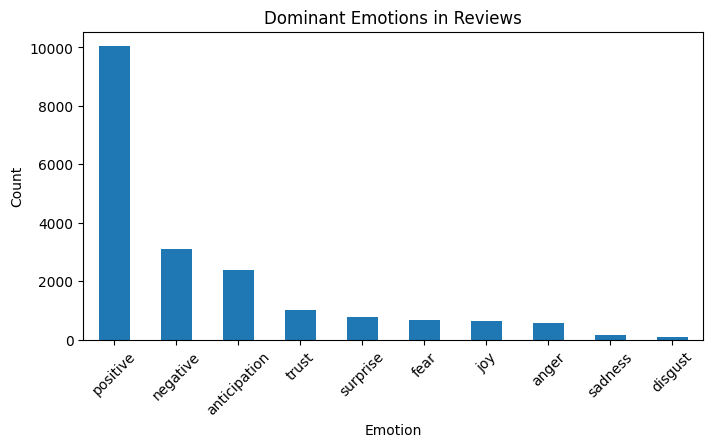

In [35]:
df['dominant_emotion'].value_counts().plot(kind='bar', figsize=(8,4))
plt.title("Dominant Emotions in Reviews")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()




## 💡 Business Insights

### **1. Customer Satisfaction Overview**

Most reviews are positive, indicating strong product acceptance.
Negative reviews highlight issues like product failures, poor accessories, or misleading descriptions.

### **2. What Customers Love**

* Long battery life
* Strong performance
* Value for money
* Ease of use

### **3. Issues Driving Negative Sentiment**

* Build quality problems
* Items arriving damaged or incomplete
* Short product lifespan
* Bad or mismatched charging accessories

### **4. Emotion Analysis Findings**

* **Anger / Disgust** → defective items, missing parts, service issues
* **Sadness** → high expectations not met, expensive failures
* **Joy / Trust** → positive experiences with performance and durability

### **5. Recommendations for Product Teams**

* Improve packaging and QA processes
* Fix commonly failing components
* Provide transparent descriptions
* Enhance customer support messaging

### **6. Marketing Recommendations**

* Emphasize top strengths: *battery*, *performance*, *value*
* Highlight reliability to invoke **trust**
* Address common complaints in FAQs/product listings

---
